In [1]:
import random
import time
import os
import json

import cv2
import numpy as np

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim

from PIL import Image
from IPython import display

from torchvision.transforms import transforms
import torch.utils.data
from torchsummary import summary

import matplotlib.pyplot as plt
import itertools

from joint_dataset import JointDomainTripletDataset, JointDomainImageDataset
from recycle_gan import RecycleGAN
from visdom_utils import MultiLinePlot

from dotmap import DotMap

device = "cuda"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"

# Colab Configuration (Local vs. Hosted)

In [2]:
using_google_gpus = False

train_X_loc = "../temporal_data_extraction/triplets/Train/Game/Train" 
test_X_loc = "../temporal_data_extraction/triplets/Train/Game/Test" 

train_Y_loc = "../temporal_data_extraction/triplets/Train/Movie/Train"
test_Y_loc = "../temporal_data_extraction/triplets/Train/Movie/Test"

run_data_directory = "./recycle_runs"

In [3]:
if using_google_gpus:
    from google.colab import drive
    drive.mount("/content/drive")
    vis = None
else:
    import visdom
    vis = visdom.Visdom()

Setting up a new session...


In [4]:
%cd drive/MyDrive/cyclegan

[WinError 3] The system cannot find the path specified: 'drive/MyDrive/cyclegan'
F:\Documents\Development\GitHub\advanced-computer-vision-y4\code\rewrite


# Data Loading

In [5]:
train_dataset = JointDomainTripletDataset(train_X_loc, train_Y_loc, train=True, img_size=256)
test_dataset = JointDomainImageDataset(test_X_loc, test_Y_loc, train=False, img_size=256, load_size=286)

In [6]:
def revert_normalisation(tensor):
    return (tensor.permute(1, 2, 0) + 1) / 2

In [7]:
test_xs = []
test_ys = []

for i in random.sample(range(0, len(test_dataset)), 16):
    x, y = test_dataset[i]
    test_xs.append(x)
    test_ys.append(y)

test_xs = torch.stack(test_xs)
test_ys = torch.stack(test_ys)

In [8]:
if vis is not None:
    vis.images(torch.stack([revert_normalisation(x).permute(2, 0, 1) for x in test_xs]), nrow=4, opts={"title": "X_test originals"})
    vis.images(torch.stack([revert_normalisation(y).permute(2, 0, 1) for y in test_ys]), nrow=4, opts={"title": "Y_test originals"})

In [9]:
test_img = test_dataset[random.randint(0, len(test_dataset))][0]

In [10]:
print(test_img.min(), test_img.max())

tensor(-1.) tensor(0.9529)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


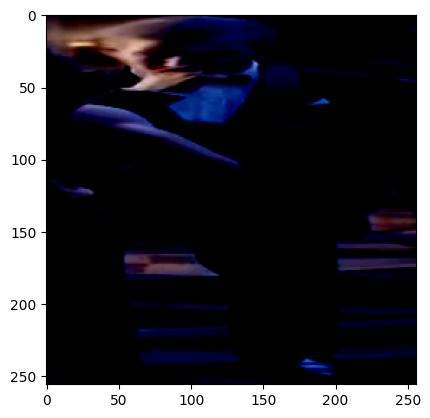

In [11]:
plt.imshow(test_img.permute(1, 2, 0))

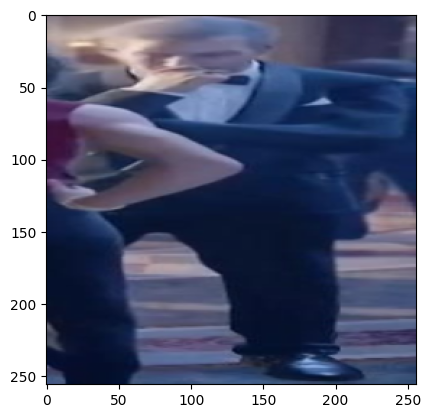

In [12]:
plt.imshow(revert_normalisation(test_img))

# Training

In [13]:
batch_size = 1
epochs = 100
lambda_weight = 5
lambda_idt_X = 0.5
lambda_idt_Y = 0.5

blocks = 6
upsample_strategy = "upsample"
pool_size = 20
opt_scheduler_type = "linear_decay_with_warmup"

checkpoint_instance_dir = None
checkpoint_epoch_dir = None

In [14]:
dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=1
)

In [15]:
if checkpoint_instance_dir is not None and checkpoint_epoch_dir is not None:
    cyclegan = RecycleGAN.load(f"./runs/{checkpoint_instance_dir}", f"{checkpoint_epoch_dir}", device, blocks)
else:
    cyclegan = RecycleGAN(blocks, upsample_strategy, device, pool_size, opt_scheduler_type, epochs)

Save folder: ./runs/RecycleGAN/1680898964.0020654
Initialised weights


In [16]:
with open(f"{cyclegan.save_folder}/info_{checkpoint_epoch_dir}.json", "w+") as fp:
    json.dump({
        "block_count": cyclegan.resnet_block_count,
        "upsample_strategy": upsample_strategy,
        "pool_size": pool_size,
        "opt_scheduler_type": opt_scheduler_type,
        "data_folders": {
            "train_X": train_X_loc,
            "test_X": test_X_loc,
            "train_Y": train_Y_loc,
            "test_Y": test_Y_loc
        },
        "batch_size": batch_size,
        "max_epochs": epochs,
        "start_epoch": cyclegan.start_epoch,
        "lambda_weight": lambda_weight,
        "lambda_idt_X": lambda_idt_X,
        "lambda_idt_Y": lambda_idt_Y,
        "checkpoint": {
            "instance": checkpoint_instance_dir,
            "epoch": checkpoint_epoch_dir
        }
    }, fp, indent=2)

In [17]:
# Could also enable random flipping
def generate_noisy_labels(shape, real, device):
    # Randomly generated between 0 and 1
    labels = torch.rand(shape, device=device)
    
    if real:
        # Now they are between 0.7 and 1.1
        labels = (2 * labels / 5) + 0.7
    else:
        # Now they are between 0 and 0.3
        labels = (labels * 3) / 10
    
    return labels

In [18]:
def get_discriminator_loss(real, fake, pool, discriminator, loss_func):
    # Discriminator should give (1) for a real image and (0) for a fake
    real_pred = discriminator(real)
    real_loss = loss_func(real_pred, generate_noisy_labels(real_pred.shape, True, device)) # Should dampen?
    
    # We draw from the history buffer
    pool_fake = pool.randomise_existing_batch(fake)
    fake_pred = discriminator(pool_fake)
    # Fake images should not fool the discriminator
    fake_loss = loss_func(fake_pred.detach(), generate_noisy_labels(fake_pred.shape, False, device))
    
    avg_loss = (real_loss + fake_loss) * 0.5
    return avg_loss

In [19]:
if cyclegan.start_epoch != 0:
    print(f"Resuming training from epoch {cyclegan.start_epoch + 1}")
else:
    print("Starting training from scratch")

if vis is not None:
    loss_plot = MultiLinePlot(vis, "Losses", "Epoch", "Loss")

for epoch in range(cyclegan.start_epoch + 1, epochs + 1):
    cyclegan.G.train()
    cyclegan.F.train()
    
    cyclegan.D_X.train()
    cyclegan.D_Y.train()
    
    cyclegan.P_X.train()
    cyclegan.P_Y.train()

    batch_start_time = time.time()
    epoch_start_time = time.time()
    
    cum_loss_idt_x = 0
    cum_loss_idt_y = 0
    cum_G_fool_loss = 0
    cum_F_fool_loss = 0
    cum_predictor_x_loss = 0
    cum_predictor_y_loss = 0
    cum_cycled_x_loss = 0
    cum_cycled_y_loss = 0
    cum_D_X_loss = 0
    cum_D_Y_loss = 0
    
    ep_loss_idt_x = 0
    ep_loss_idt_y = 0
    ep_G_fool_loss = 0
    ep_F_fool_loss = 0
    ep_predictor_x_loss = 0
    ep_predictor_y_loss = 0
    ep_cycled_x_loss = 0
    ep_cycled_y_loss = 0
    ep_D_X_loss = 0
    ep_D_Y_loss = 0
    
    for batch_no, ((x_0, x_1, x_2), (y_0, y_1, y_2)) in enumerate(dataloader):
        # Load the sequence of frames to the GPU
        x_0 = x_0.to(device)
        x_1 = x_1.to(device)
        x_2 = x_2.to(device)
        
        y_0 = y_0.to(device)
        y_1 = y_1.to(device)
        y_2 = y_2.to(device)
        
        # Firstly, generate fake images in domain Y using the x_t images
        fake_y_0 = cyclegan.G(x_0)
        fake_y_1 = cyclegan.G(x_1)
        
        # For the final frame we use the predictor model, we are doing this in domain Y space so use P_Y not P_X
        fake_y_2 = cyclegan.P_Y(torch.cat((fake_y_0, fake_y_1), 1))
        
        # Then generate the fake images in domain X using the y_t images
        fake_x_0 = cyclegan.F(y_0)
        fake_x_1 = cyclegan.F(y_1)
        # For the final frame we use the predictor model, we are doing this in domain X space so use P_X not P_Y
        fake_x_2 = cyclegan.P_X(torch.cat((fake_x_0, fake_x_1), 1))
        
        ### GENERATOR TRAINING
        
        # Freeze discriminator weights
        for param in cyclegan.D_X.parameters():
            param.requires_grad = False

        for param in cyclegan.D_Y.parameters():
            param.requires_grad = False
        
        # Zero the gradients for the generators and predictors
        cyclegan.G_opt.zero_grad()
        cyclegan.F_opt.zero_grad()
        cyclegan.P_X_opt.zero_grad()
        cyclegan.P_Y_opt.zero_grad()
        
        # Calculate the identity loss, this tries to enforce that G(y) = I(y) = y i.e. the identity
        idt_x_0 = cyclegan.F(x_0)
        idt_x_1 = cyclegan.F(x_1)
        loss_idt_x = cyclegan.identity_loss(idt_x_0, x_0) + cyclegan.identity_loss(idt_x_1, x_1)
        
        idt_y_0 = cyclegan.G(y_0)
        idt_y_1 = cyclegan.G(y_1)
        loss_idt_y = cyclegan.identity_loss(idt_y_0, y_0) + cyclegan.identity_loss(idt_y_1, y_1)
        
        # Now we try and fool the discriminators
        # D_X tries to tell if an image is from X (1) or from F(Y) (0) so it takes input fake_x_t
        # D_X is supposed to be 1 if the image is from X but here we are trying to get it to be 1 if it is from G(X) -> Y which is incorrect
        G_fool_0 = cyclegan.D_Y(fake_y_0) 
        # We want to tell if fake_y_0 has fooled D_X, so we measure how far from the output 1 it is 
        G_fool_loss_0 = cyclegan.gan_loss(G_fool_0, generate_noisy_labels(G_fool_0.shape, True, device))
        
        G_fool_1 = cyclegan.D_Y(fake_y_1)
        G_fool_loss_1 = cyclegan.gan_loss(G_fool_1, generate_noisy_labels(G_fool_1.shape, True, device))
        
        G_fool_2 = cyclegan.D_Y(fake_y_2)
        G_fool_loss_2 = cyclegan.gan_loss(G_fool_2, generate_noisy_labels(G_fool_2.shape, True, device))
        
        G_fool_loss = G_fool_loss_0 + G_fool_loss_1 + G_fool_loss_2
        
        # D_Y tries to tell if an image is from Y (1) or from G(X) (0) so it takes input fake_y_t
        F_fool_0 = cyclegan.D_X(fake_x_0)
        # We want to tell if fake_x_0 has fooled D_Y, so we measure how far from the output 1 it is 
        F_fool_loss_0 = cyclegan.gan_loss(F_fool_0, generate_noisy_labels(F_fool_0.shape, True, device))
        
        F_fool_1 = cyclegan.D_X(fake_x_1)
        F_fool_loss_1 = cyclegan.gan_loss(F_fool_1, generate_noisy_labels(F_fool_1.shape, True, device))
        
        F_fool_2 = cyclegan.D_X(fake_x_2)
        F_fool_loss_2 = cyclegan.gan_loss(F_fool_2, generate_noisy_labels(F_fool_2.shape, True, device))
        
        F_fool_loss = F_fool_loss_0 + F_fool_loss_1 + F_fool_loss_2
        
        # Now we train the predictors on the real images using the recurrent loss
        # x_2 first
        predicted_x_2 = cyclegan.P_X(torch.cat((x_0, x_1), 1))
        predicted_x_loss = cyclegan.recurrent_loss(predicted_x_2, x_2)
        
        # So recycled_x_2 = F(P_Y(G(x_0), G(x_1)))
        recycled_x_2 = cyclegan.F(fake_y_2)
        recycled_x_loss = cyclegan.recycle_loss(recycled_x_2, x_2)
        
        predictor_x_loss = predicted_x_loss + recycled_x_loss
        
        # now y_2
        predicted_y_2 = cyclegan.P_Y(torch.cat((y_0, y_1), 1))
        predicted_y_loss = cyclegan.recurrent_loss(predicted_y_2, y_2)
        
        # So recycled_y_2 = G(P_X(F(y_0), F(y_1)))
        recycled_y_2 = cyclegan.G(fake_x_2)
        recycled_y_loss = cyclegan.recycle_loss(recycled_y_2, y_2)
        
        predictor_y_loss = predicted_y_loss + recycled_y_loss
        
        # Now do the cycle loss
        cycled_x_0 = cyclegan.F(fake_y_0)
        cycled_loss_x_0 = cyclegan.cycle_loss(cycled_x_0, x_0)
        
        cycled_x_1 = cyclegan.F(fake_y_1)
        cycled_loss_x_1 = cyclegan.cycle_loss(cycled_x_1, x_1)
        
        cycled_loss_x = cycled_loss_x_0 + cycled_loss_x_1
        
        cycled_y_0 = cyclegan.G(fake_x_0)
        cycled_loss_y_0 = cyclegan.cycle_loss(cycled_y_0, y_0)
        
        cycled_y_1 = cyclegan.G(fake_x_1)
        cycled_loss_y_1 = cyclegan.cycle_loss(cycled_y_1, y_1)
        
        cycled_loss_y = cycled_loss_y_0 + cycled_loss_y_1
        
        # Backpropagate and step the gradients
        generator_loss = G_fool_loss + F_fool_loss + lambda_weight * (cycled_loss_x + cycled_loss_y + predictor_x_loss + predictor_y_loss + lambda_idt_X * loss_idt_x + lambda_idt_Y * loss_idt_y)
        generator_loss.backward()
        
        cyclegan.G_opt.step()
        cyclegan.F_opt.step()
        cyclegan.P_X_opt.step()
        cyclegan.P_Y_opt.step()
        
        del G_fool_0
        del G_fool_1
        del G_fool_2
        del F_fool_0
        del F_fool_1
        del F_fool_2
        
        ### DISCRIMINATOR TRAINING
        # Unfreeze discriminator weights
        for param in cyclegan.D_X.parameters():
            param.requires_grad = True

        for param in cyclegan.D_Y.parameters():
            param.requires_grad = True
        
        # Zero the gradients
        cyclegan.D_X_opt.zero_grad()
        cyclegan.D_Y_opt.zero_grad()
        
        D_X_loss_0 = get_discriminator_loss(x_0, fake_x_0, cyclegan.fake_X_buffer, cyclegan.D_X, cyclegan.gan_loss)
        D_X_loss_1 = get_discriminator_loss(x_1, fake_x_1, cyclegan.fake_X_buffer, cyclegan.D_X, cyclegan.gan_loss)
        D_X_loss_fake_pred = get_discriminator_loss(x_2, fake_x_2, cyclegan.fake_X_buffer, cyclegan.D_X, cyclegan.gan_loss)
        D_X_loss_real_pred = get_discriminator_loss(x_2, predicted_x_2, cyclegan.fake_X_buffer, cyclegan.D_X, cyclegan.gan_loss)
        D_X_loss = D_X_loss_0 + D_X_loss_1 + D_X_loss_fake_pred + D_X_loss_real_pred
        
        D_Y_loss_0 = get_discriminator_loss(y_0, fake_y_0, cyclegan.fake_Y_buffer, cyclegan.D_Y, cyclegan.gan_loss)
        D_Y_loss_1 = get_discriminator_loss(y_1, fake_y_1, cyclegan.fake_Y_buffer, cyclegan.D_Y, cyclegan.gan_loss)
        D_Y_loss_fake_pred = get_discriminator_loss(y_2, fake_y_2, cyclegan.fake_Y_buffer, cyclegan.D_Y, cyclegan.gan_loss)
        D_Y_loss_real_pred = get_discriminator_loss(y_2, predicted_y_2, cyclegan.fake_Y_buffer, cyclegan.D_Y, cyclegan.gan_loss)
        D_Y_loss = D_Y_loss_0 + D_Y_loss_1 + D_Y_loss_fake_pred + D_Y_loss_real_pred
        
        # Backpropagate and step the gradients
        D_loss = D_X_loss + D_Y_loss
        D_loss.backward()
        
        cyclegan.D_X_opt.step()
        cyclegan.D_Y_opt.step()
        
        ### UPDATE POOLS
        cyclegan.fake_X_buffer.add(fake_x_0.detach())
        cyclegan.fake_X_buffer.add(fake_x_1.detach())
        cyclegan.fake_X_buffer.add(fake_x_2.detach())
        
        cyclegan.fake_Y_buffer.add(fake_y_0.detach())
        cyclegan.fake_Y_buffer.add(fake_y_1.detach())
        cyclegan.fake_Y_buffer.add(fake_y_2.detach())
        
        ### TRACK LOSS
        cum_loss_idt_x += loss_idt_x.item()
        cum_loss_idt_y += loss_idt_y.item()
        cum_G_fool_loss += G_fool_loss.item()
        cum_F_fool_loss += F_fool_loss.item()
        cum_predictor_x_loss += predictor_x_loss.item()
        cum_predictor_y_loss += predictor_y_loss.item()
        cum_cycled_x_loss += cycled_loss_x.item()
        cum_cycled_y_loss += cycled_loss_y.item()
        cum_D_X_loss += D_X_loss.item()
        cum_D_Y_loss += D_Y_loss.item()
        
        ep_loss_idt_x += loss_idt_x.item()
        ep_loss_idt_y += loss_idt_y.item()
        ep_G_fool_loss += G_fool_loss.item()
        ep_F_fool_loss += F_fool_loss.item()
        ep_predictor_x_loss += predictor_x_loss.item()
        ep_predictor_y_loss += predictor_y_loss.item()
        ep_cycled_x_loss += cycled_loss_x.item()
        ep_cycled_y_loss += cycled_loss_y.item()
        ep_D_X_loss += D_X_loss.item()
        ep_D_Y_loss += D_Y_loss.item()
        
        if epoch == 0 and batch_no < 55:
            print(f"[{epoch}:{batch_no}] fake_X_buffer: {len(cyclegan.fake_X_buffer)}, fake_Y_buffer: {len(cyclegan.fake_Y_buffer)}")
        
        if batch_no % 100 == 0 and batch_no != 0: 
            duration = time.time() - batch_start_time
            
            updated_losses = {
                "loss_idt_x": cum_loss_idt_x / 100,
                "loss_idt_y": cum_loss_idt_y / 100,
                "G_fool_loss": cum_G_fool_loss / 100,
                "F_fool_loss": cum_F_fool_loss / 100,
                "predictor_x_loss": cum_predictor_x_loss / 100,
                "predictor_y_loss": cum_predictor_y_loss / 100,
                "cycled_x_loss": cum_cycled_x_loss / 100,
                "cycled_y_loss": cum_cycled_y_loss / 100,
                "D_X_loss": cum_D_X_loss / 100,
                "D_Y_loss": cum_D_Y_loss / 100
            }
            
            x_loss_str = f"[{epoch}:{batch_no}]"
            y_loss_str = f"[{epoch}:{batch_no}]"
            
            for i, (key, value) in enumerate(updated_losses.items()):
                if i % 2 == 0:
                    x_loss_str = f"{x_loss_str} {key}: {value},"
                else:
                    y_loss_str = f"{y_loss_str} {key}: {value},"
            
            x_loss_str = x_loss_str[:-1]
            y_loss_str = y_loss_str[:-1]

            print(f"[{epoch}:{batch_no}] Took {duration:.2f}s")
            print(x_loss_str)
            print(y_loss_str)
            print(f"[{epoch}:{batch_no}] fake_X_buffer: {len(cyclegan.fake_X_buffer)}, fake_Y_buffer: {len(cyclegan.fake_Y_buffer)}")
            
            if vis is not None:
                loss_plot.append_values(epoch + batch_no / len(dataloader), updated_losses)
            
            cum_loss_idt_x = 0
            cum_loss_idt_y = 0
            cum_G_fool_loss = 0
            cum_F_fool_loss = 0
            cum_predictor_x_loss = 0
            cum_predictor_y_loss = 0
            cum_cycled_x_loss = 0
            cum_cycled_y_loss = 0
            cum_D_X_loss = 0
            cum_D_Y_loss = 0

            batch_start_time = time.time()
    
    print(f"[{epoch}:END] Completed epoch in {time.time() - epoch_start_time}s")
    
    print(f"[{epoch}:{batch_no}]", 
          f"ep_loss_idt_x: {ep_loss_idt_x / len(dataloader):.3f}", 
          f"ep_G_fool_loss: {ep_G_fool_loss / len(dataloader):.3f}", 
          f"ep_predictor_x_loss: {ep_predictor_x_loss / len(dataloader):.3f}", 
          f"ep_cycled_x_loss: {ep_cycled_x_loss / len(dataloader):.3f}",
          f"ep_D_X_loss: {ep_D_X_loss / len(dataloader):.3f}")
    
    print(f"[{epoch}:{batch_no}]", 
          f"ep_loss_idt_y: {ep_loss_idt_y / len(dataloader):.3f}", 
          f"ep_F_fool_loss: {ep_F_fool_loss / len(dataloader):.3f}", 
          f"ep_predictor_y_loss: {ep_predictor_y_loss / len(dataloader):.3f}", 
          f"ep_cycled_y_loss: {ep_cycled_y_loss / len(dataloader):.3f}",
          f"ep_D_Y_loss: {ep_D_Y_loss / len(dataloader):.3f}")
    
    cyclegan.G.eval()
    cyclegan.F.eval()
    
    if vis is not None:
        eval_start_time = time.time()

        G_eval_forward = cyclegan.apply(test_xs, x_to_y=True)
        F_eval_forward = cyclegan.apply(test_ys, x_to_y=False)

        G_rev = cyclegan.apply(G_eval_forward, x_to_y=False)
        F_rev = cyclegan.apply(F_eval_forward, x_to_y=True)

        G_eval_forward = torch.stack([revert_normalisation(x).permute(2, 0, 1) for x in G_eval_forward])
        F_eval_forward = torch.stack([revert_normalisation(x).permute(2, 0, 1) for x in F_eval_forward])
        G_rev = torch.stack([revert_normalisation(x).permute(2, 0, 1) for x in G_rev])
        F_rev = torch.stack([revert_normalisation(x).permute(2, 0, 1) for x in F_rev])

        G_eval_grid = torchvision.utils.make_grid(G_eval_forward, nrow=4)
        F_eval_grid = torchvision.utils.make_grid(F_eval_forward, nrow=4)
        G_rev_grid = torchvision.utils.make_grid(G_rev, nrow=4)
        F_rev_grid = torchvision.utils.make_grid(F_rev, nrow=4)
        
        folder = f"{cyclegan.save_folder}/{epoch}"
        os.makedirs(folder, exist_ok=True)
        
        torchvision.utils.save_image(G_eval_grid, f"{folder}/X_to_Y.png")
        torchvision.utils.save_image(F_eval_grid, f"{folder}/Y_to_X.png")
        torchvision.utils.save_image(G_rev_grid, f"{folder}/X_to_Y_to_X.png")
        torchvision.utils.save_image(F_rev_grid, f"{folder}/Y_to_X_to_Y.png")

        vis.image(G_eval_grid, win="G_eval", opts={
            "caption": f"X -> Y evaluation, epoch {epoch}",
            "store_history": True
        })

        vis.image(F_eval_grid, win="F_eval", opts={
            "caption": f"Y -> X evaluation, epoch {epoch}",
            "store_history": True
        })

        vis.image(G_rev_grid, win="G_rev", opts={
            "caption": f"X -> Y -> X evaluation, epoch {epoch}",
            "store_history": True
        })

        vis.image(F_rev_grid, win="F_rev", opts={
            "caption": f"Y -> X -> Y evaluation, epoch {epoch}",
            "store_history": True
        })
        
        

        print(f"[{epoch}:END] Completed eval in {time.time() - eval_start_time}s")

    cyclegan.G.train()
    cyclegan.F.train()

    cyclegan.step_learning_rates()

    if epoch % 5 == 0 or epoch == 1:
        print(f"[{epoch}:END] Saving models and training information permanently")
        cyclegan.save(epoch, full_save=True)
        cyclegan.save(epoch, full_save=True, folder="latest")
    else:
        print(f"[{epoch}:END] Saving models and training information temporarily to latest and saving generators permanently")
        cyclegan.save(epoch, full_save=True, folder="latest")
        cyclegan.save(epoch, full_save=False)


Starting training from scratch
[1:100] Took 128.80s
[1:100] loss_idt_x: 0.5541572569310665, G_fool_loss: 1.2144887962937354, predictor_x_loss: 0.5378934526443482, cycled_x_loss: 0.5712447628378868, D_X_loss: 2.9364376056194303
[1:100] loss_idt_y: 0.5900187434256077, F_fool_loss: 1.1524032039940357, predictor_y_loss: 0.6516065680980683, cycled_y_loss: 0.6338832598924636, D_Y_loss: 2.9707430136203765
[1:100] fake_X_buffer: 20, fake_Y_buffer: 20
[1:200] Took 115.73s
[1:200] loss_idt_x: 0.4161659163236618, G_fool_loss: 0.24905044183135033, predictor_x_loss: 0.3754124814271927, cycled_x_loss: 0.43967310324311254, D_X_loss: 1.4462473320960998
[1:200] loss_idt_y: 0.4895300783216953, F_fool_loss: 0.2763815892487764, predictor_y_loss: 0.4596289026737213, cycled_y_loss: 0.5378765086829662, D_Y_loss: 1.3951566183567048
[1:200] fake_X_buffer: 20, fake_Y_buffer: 20
[1:300] Took 115.53s
[1:300] loss_idt_x: 0.42299161195755003, G_fool_loss: 0.16848139703273773, predictor_x_loss: 0.35075939163565634, 